In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [3]:
def unicode_to_ascii(s):
  return "".join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  w = '<start> ' + w + ' <end>'
  return w

In [4]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode("utf-8"))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [5]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding="UTF-8").read().strip().split("\n")

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

  return zip(*word_pairs)

In [6]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [7]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                padding='post')
  
  return tensor, lang_tokenizer

In [8]:
def load_dataset(path, num_examples=None):
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [10]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [11]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f"{t} ----> {lang.index_word[t]}")

In [12]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
140 ----> si
32 ----> ,
12 ----> me
40 ----> gusta
4 ----> tom
3 ----> .
2 ----> <end>
Target Language; index to word mapping
1 ----> <start>
4 ----> i
22 ----> do
35 ----> like
5 ----> tom
3 ----> .
2 ----> <end>


In [13]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [14]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [15]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [16]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print(f"Encoder output shape: (batch size, sequence length, length units) {sample_output.shape}")
print(f"Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}")

Encoder output shape: (batch size, sequence length, length units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [18]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print(f"Attention result shape: (batch size, units) {attention_result.shape}")
print(f"Attention weights shape: (batch_size, sequence_length, 1) {attention_weights.shape}")

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [19]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.dec_units)
  
  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print(f"Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}")

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [22]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [23]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      dec_input = tf.expand_dims(targ[:, t], 1)
  
  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [24]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f"Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}")
  
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
  
  print(f"Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}")
  print(f"Time taken for 1 epoch {time.time() - start} sec\n")

Epoch 1 Batch 0 Loss 4.5903
Epoch 1 Batch 100 Loss 2.2259
Epoch 1 Batch 200 Loss 1.7989
Epoch 1 Batch 300 Loss 1.7603
Epoch 1 Loss 2.0222
Time taken for 1 epoch 45.22928333282471 sec

Epoch 2 Batch 0 Loss 1.5287
Epoch 2 Batch 100 Loss 1.4933
Epoch 2 Batch 200 Loss 1.3927
Epoch 2 Batch 300 Loss 1.2640
Epoch 2 Loss 1.3725
Time taken for 1 epoch 33.023695945739746 sec

Epoch 3 Batch 0 Loss 1.0572
Epoch 3 Batch 100 Loss 0.9761
Epoch 3 Batch 200 Loss 0.9463
Epoch 3 Batch 300 Loss 0.7481
Epoch 3 Loss 0.9658
Time taken for 1 epoch 31.979158639907837 sec

Epoch 4 Batch 0 Loss 0.7284
Epoch 4 Batch 100 Loss 0.6479
Epoch 4 Batch 200 Loss 0.6271
Epoch 4 Batch 300 Loss 0.5862
Epoch 4 Loss 0.6618
Time taken for 1 epoch 32.57169556617737 sec

Epoch 5 Batch 0 Loss 0.4804
Epoch 5 Batch 100 Loss 0.4200
Epoch 5 Batch 200 Loss 0.4564
Epoch 5 Batch 300 Loss 0.5467
Epoch 5 Loss 0.4523
Time taken for 1 epoch 32.14606189727783 sec

Epoch 6 Batch 0 Loss 0.3171
Epoch 6 Batch 100 Loss 0.2932
Epoch 6 Batch 200 Lo

In [35]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(" ")]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding="post")
  inputs = tf.convert_to_tensor(inputs)

  result = ""

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + " "

    if targ_lang.index_word[predicted_id] == "<end>":
      return result, sentence, attention_plot
    
    dec_input = tf.expand_dims([predicted_id], 0)
  
  return result, sentence, attention_plot

In [31]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize':14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [32]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print(f"Input: {sentence}")
  print(f"Predicted translation: {result}")

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(" "), result.split(" "))

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


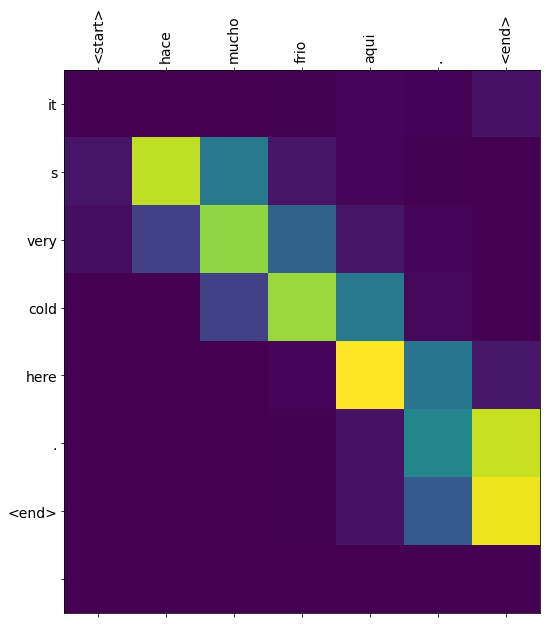

In [36]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


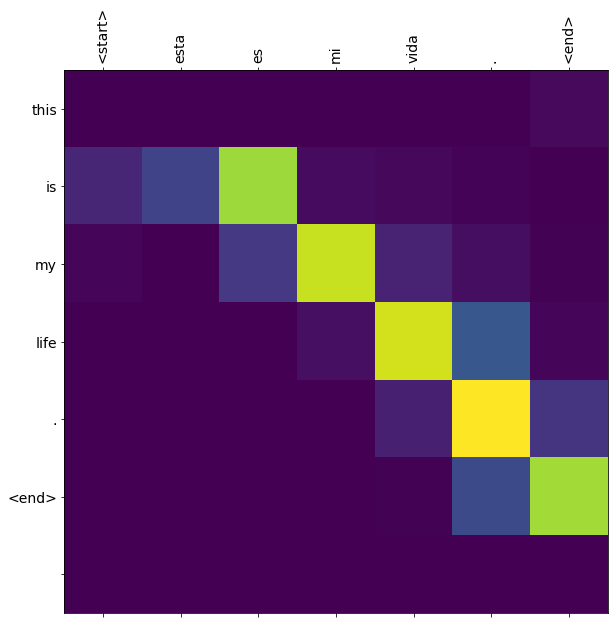

In [37]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still home ? <end> 


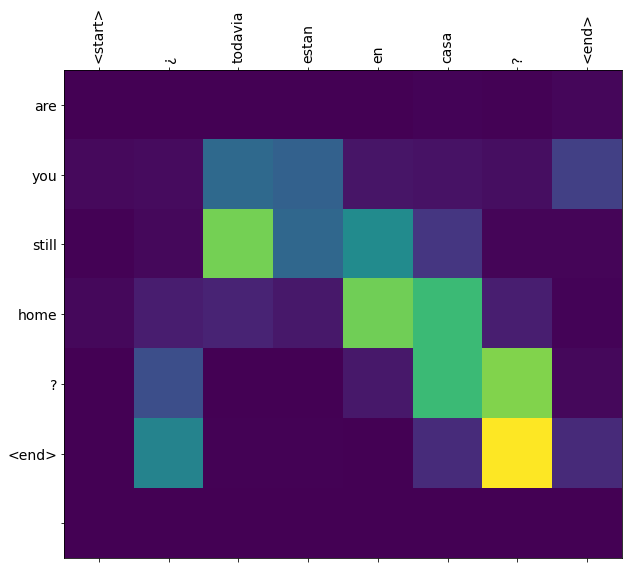

In [38]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


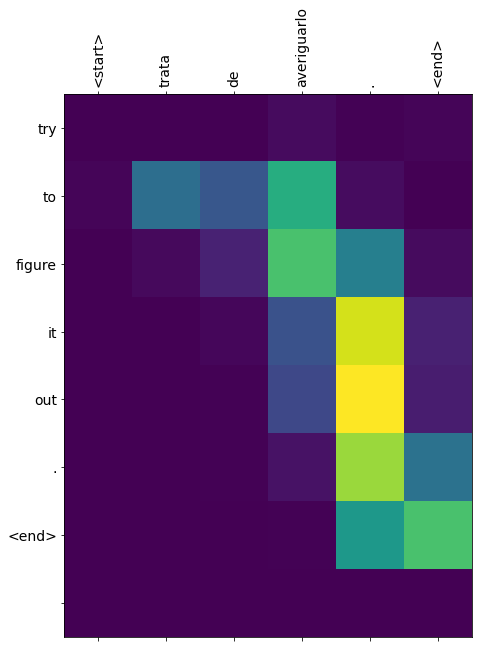

In [39]:
translate(u'trata de averiguarlo.')